Eric Chaves Sánchez - 1633944  
Enric Rodríguez Bafalluy - 1632398


Utilitzem el dataset de kaggle que trobem a <a href="https://www.kaggle.com/datasets/datasnaek/league-of-legends">https://www.kaggle.com/datasets/datasnaek/league-of-legends</a> que es un dataset amb dades sobre el videojoc 
League Of Legends, el nostre objectiu es crear un model el qual sigui capaç de predir si una partida s'ha guanyat o no.



In [60]:
from zipfile import ZipFile
from copy import deepcopy
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
from sklearn.metrics import  precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from sklearn.linear_model import LogisticRegression
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.svm import SVC

api = KaggleApi()
#api.config  = os.path.join(os.getcwd(),'kaggle.json')
api.authenticate()

dataser_owner = 'datasnaek'
dataset_name= 'league-of-legends'
dataset = f'{dataser_owner}/{dataset_name}'

if not os.path.isdir('data_kaggle'):
  os.mkdir('data_kaggle')
  api.dataset_download_files(dataset = dataset,path = 'data_kaggle')
  zf = ZipFile(f'data_kaggle/{dataset_name}.zip')
  zf.extractall(f'data_kaggle/{dataset_name}') #save files in selected folder
  zf.close()
df = pd.read_csv(f'data_kaggle/{dataset_name}/games.csv')
print(df.head(10))

       gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0  3326086514  1504279457970          1949         9       1           2   
1  3229566029  1497848803862          1851         9       1           1   
2  3327363504  1504360103310          1493         9       1           2   
3  3326856598  1504348503996          1758         9       1           1   
4  3330080762  1504554410899          2094         9       1           2   
5  3287435705  1501667992132          2059         9       1           2   
6  3314215542  1503430065724          1993         9       1           1   
7  3329224025  1504472363684          1334         9       1           1   
8  3318040883  1503686577549          1387         9       2           2   
9  3327786881  1504385918871          2681         9       2           2   

   firstTower  firstInhibitor  firstBaron  firstDragon  ...  t2_towerKills  \
0           1               1           1            1  ...              5   
1      

Ara carreguem un archiu anomenat champion_info.json que ens proporciona el propi dataset de kaggle, l'utilizarem mes endavant. 

In [61]:
file_path=f"data_kaggle/{dataset_name}/champion_info.json"

with open(file_path, 'r', encoding='utf-8') as file:
    data_json = json.load(file)
    file.close()
#print(data)

### 1. EDA (exploratory data analysis)
Veiem que la nostra base de dades te 61 atributs. On tenim tant atributs númerics continus com son: creationTime, gameDuration. Tots els altres valors son valors discrets, degut a que nomès poden prendre un cert conjunt de valors per exemple GameId només pren uns valors que es troben en un rang acotat. Les columnes que son "bans" o "champ" també prenen uns valors concrets que son els numeros identificadors de personatges que hi ha hal joc. No trobem Nans en les dades. 
A simple vista no trobem cap relació entre Y(winner) i les altres dades. 
Les dades no es trobem massa balancejades els diferents atributs, el que ens podria arribar afectar a la classificació


In [62]:
print(df.shape)

missing_values = df.isna().sum()

print("\nValores faltantes en cada atributo:")
print(missing_values)


(51490, 61)

Valores faltantes en cada atributo:
gameId          0
creationTime    0
gameDuration    0
seasonId        0
winner          0
               ..
t2_ban1         0
t2_ban2         0
t2_ban3         0
t2_ban4         0
t2_ban5         0
Length: 61, dtype: int64


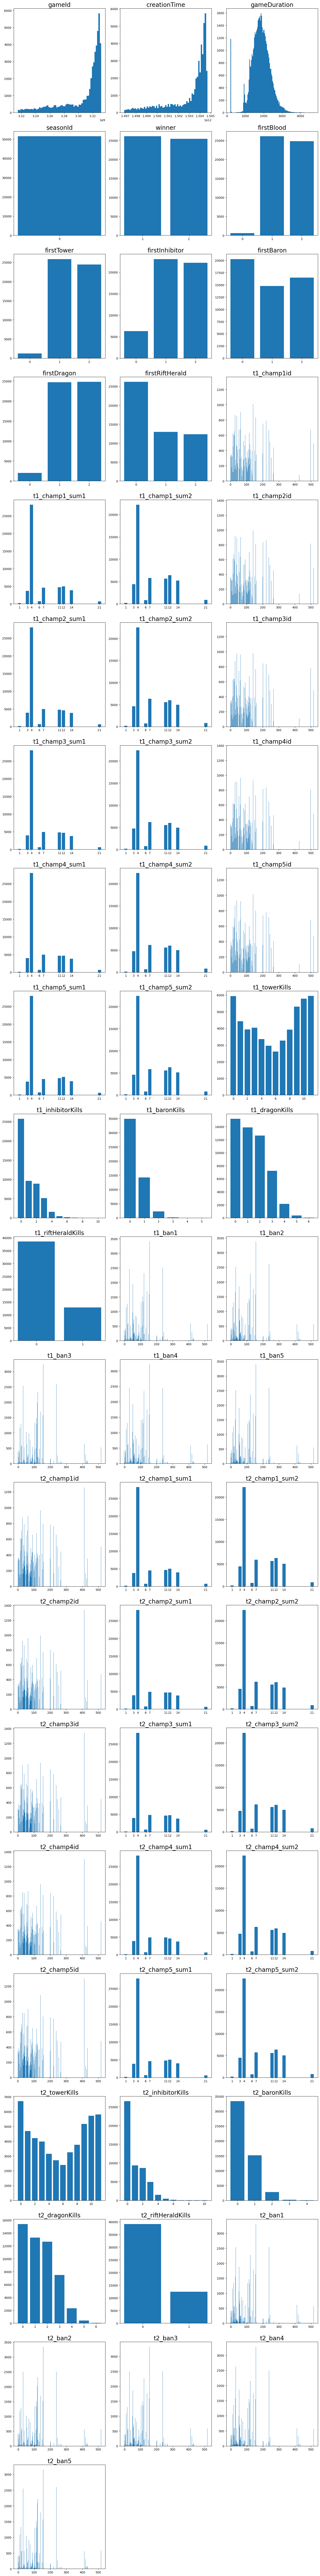

In [63]:
#tarda una bona estona ~2min
plt.figure(figsize=(15, 120))

m=1


for i in df: 
    plt.subplot(21,3, m)
    m+=1
    if i in ['gameId', 'creationTime', "gameDuration"]:  # Puedes añadir otros tipos numéricos si es necesario
        plt.hist(df[i], bins="auto")
        plt.title(i, fontsize=20)
    else:
        x=df[i].value_counts()
        
        plt.title(i, fontsize=20)

        plt.bar(x.keys(),x)
        if len(x.keys())<=10: 
            plt.xticks(x.keys(),  fontsize=10)

plt.tight_layout()
plt.show()

### 2. Preprocessing

GameId es el identificador de la partida que es repeteix. No ens interesa degut a que un mateix gameID tindra sempre la mateixa prediccio de si guanya o pert, perjudicant el patró que reconeixeria el model.
I l'identificador de la sessió ("seasonId") té sempre el mateix valor, es a dir totes les partides son del mateix any/temporada. També hem optat per eliminar creationTime ja que no ens dona cap informació extra, ja que vol dir just el temps quan s'ha creat la partida.

In [64]:

df=df.drop(["gameId", "seasonId", "creationTime"], axis=1)
print(df.shape)

(51490, 58)


Al League of Legends,  hem pensat que en el cas de que hi hagui en la variable gameDuration valors propers a zero vol dir que els jugadors del equip s'han rendit rapidament(posiblement perque un jugador s'ha desconectat),això es degut a que el joc ens dona l'opció a abandonar en quan passa aixó. Quan en aquest tipus de partida et rendeixes en un temps inferior al minut 5 no compta ni com a victoria ni derrota, aquestes partides no les tindrem en compte. Per tant els valors anomals que son inferiors 500 segons, que es un temps de partida molt petit els treiem perque son rendicions o valors que no poden ocorrer.

In [65]:
df=filtrado = df[df['gameDuration'] > 500] 

Ara tornem a mirar els valors ja que hi ha unes altres columnes que han canviat degut aixo. 

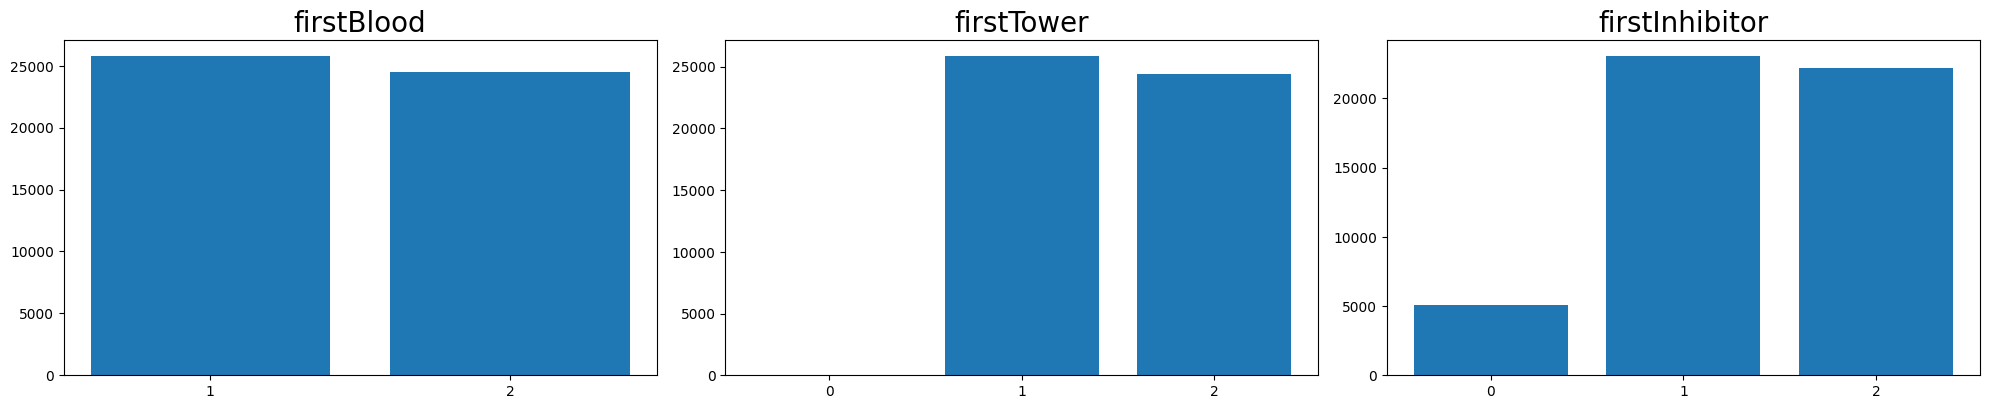

firstTower
1    25861
2    24415
0       18
Name: count, dtype: int64


In [66]:
plt.figure(figsize=(20, 75))

m=1
columnes=["firstBlood", "firstTower", "firstInhibitor"]
for i in columnes: 
    plt.subplot(20,3, m)
    m+=1
    x=df[i].value_counts()

    plt.title(i, fontsize=20)

    plt.bar(x.keys(),x)
    if len(x.keys())<=10: 
        plt.xticks(x.keys(),  fontsize=10)

plt.tight_layout()
plt.show()
print(df["firstTower"].value_counts())

Veiem que tenim molts pocs valors amb firstTower=0, degut a que sempre a la partida es tiren torres. Llavors que no es tiri cap torre pot ser 2 opcions: un Nan o que s'hagin rendit abans de tirar cap torre.
El que farem es posar els valors 0 a la moda.

In [67]:
df[df["firstTower"]==0]= df["firstTower"].mode()[0]
print(df["firstTower"].value_counts())

firstTower
1    25879
2    24415
Name: count, dtype: int64


Finalment veiem que el dataset es troba balancejat sobre la classe que volem predir. 

In [68]:
df["winner"].value_counts(normalize=True)

winner
1    0.506363
2    0.493637
Name: proportion, dtype: float64

Ara generarem noves columnes segons el tipus de personatge que es juga(normalment els personatges s'anomenen campions). Gracies a que tenim l'arxiu champion_info podem clasificar els campions segons els seu tipus, ja que podem saber el tipus de cada campió entrant a diverses pagines sobre League Of Legends i també amb els nostres conexiements sobre el joc. 

Per tant creem el següent diccionari: 

In [69]:

#tipos utilitzados para clasificar de manera simplista: "Mago", "Guerrero", "Tanque", "Apoyo", "Tirador", "Asesino"  i un campio pot tenir mes d'un tipus
champ_by_tipus={
    "Annie": ["Mago"], 
    "Olaf": ["Guerrero"], 
    "Galio": ["Tanque", "Mago"], 
    "Twisted Fate": ["Mago", "Tirador"], 
    "Xin Zhao": ["Guerrero"], 
    "Urgot": ["Tanque", "Guerrero"], 
    "LeBlanc": ["Mago"], 
    "Vladimir": ["Mago"], 
    "Fiddlesticks": ["Mago"], 
    "Kayle": ["Mago", "Tirador"], 
    "Master Yi": ["Asesino"], 
    "Alistar": ["Tanque"], 
    "Ryze": ["Mago"], 
    "Sion": ["Tanque"], 
    "Sivir": ["Tirador"], 
    "Soraka": ["Apoyo"], 
    "Teemo": ["Mago", "Tirador"], 
    "Tristana": ["Tirador"], 
    "Warwick": ["Guerrero"], 
    "Ashe": ["Tirador"], 
    "Miss Fortune":["Tirador"], 
    "Nunu": ["Tanque", "Mago"], 
    "Tryndamere": ["Guerrero"], 
    "Jax": ["Guerrero"], 
    "Morgana": ["Apoyo", "Mago"], 
    "Zilean": ["Apoyo", "Mago"], 
    "Singed": ["Tanque", "Mago"], 
    "Evelynn": ["Asesino", "Mago"], 
    "Twitch" : ["Tirador", "Mago"],
    "Karthus": ["Mago"], 
    "Cho'Gath": ["Tanque"], 
    "Amumu": ["Tanque"], 
    "Rammus":["Tanque"], 
    "Anivia": ["Mago"], 
    "Shaco": ["Asesino"],
    "Dr. Mundo":["Tanque"], 
    "Sona":["Apoyo"], 
    "Kassadin": ["Mago", "Asesino"], 
    "Irelia": ["Guerrero"], 
    "Janna": ["Apoyo"], 
    "Gangplank": ["Guerrero"], 
    "Corki":  ["Tirador"], 
    "Karma": ["Apoyo"], 
    "Taric":["Tanque", "Apoyo"], 
    "Veigar":["Mago"], 
    "Trundle":["Guerrero"], 
    "Swain": ["Tanque", "Mago"], 
    "Caitlyn": ["Tirador"], 
    "Blitzcrank": ["Apoyo"], 
    "Malphite": ["Tanque"], 
    "Katarina": ["Mago", "Asesino"], 
    "Nocturne": ["Asesino"], 
    "Maokai": ["Tanque"], 
    "Renekton": ["Guerrero"], 
    "Jarvan IV": ["Guerrero"], 
    "Elise": ["Mago", "Asesino"], 
    "Orianna": ["Mago"], 
    "Wukong": ["Guerrero"], 
    "Brand": ["Mago"], 
    "Lee Sin": ["Guerrero"], 
    "Vayne": ["Tirador"], 
    "Rumble": ["Mago"], 
    "Cassiopeia": ["Mago"], 
    "Skarner": ["Tanque"], 
    "Heimerdinger": ["Mago"], 
    "Nasus": ["Tanque", "Guerrero"], 
    "Nidalee": ["Mago", "Guerrero"], 
    "Udyr": ["Tanque", "Guerrero"], 
    "Poppy": ["Tanque"], 
    "Gragas": ["Tanque", "Mago"], 
    "Pantheon": ["Guerrero"], 
    "Ezreal": ["Tirador"], 
    "Mordekaiser": ["Tanque", "Mago"], 
    "Yorick": ["Tanque"], 
    "Akali": ["Asesino", "Mago"], 
    "Kennen": ["Tirador", "Mago"], 
    "Garen": ["Guerrero"], 
    "Leona": ["Tanque"], 
    "Malzahar": ["Mago"], 
    "Talon": ["Asesino"],
    "Riven": ["Guerrero"], 
    "Kog'Maw": ["Tirador"], 
    "Shen": ["Tanque", "Apoyo"], 
    "Lux": ["Mago"], 
    "Xerath": ["Mago"], 
    "Shyvana": ["Guerrero", "Mago"], 
    "Ahri": ["Asesino", "Mago"], 
    "Graves": ["Tirador"], 
    "Fizz": ["Asesino", "Mago"], 
    "Volibear": ["Guerrero", "Mago"],
    "Rengar": ["Asesino"], 
    "Varus": ["Tirador", "Mago"], 
    "Nautilus": ["Tanque"], 
    "Viktor": ["Mago"], 
    "Sejuani": ["Tanque"], 
    "Fiora": ["Guerrero"], 
    "Ziggs": ["Mago"], 
    "Lulu": ["Apoyo"], 
    "Draven": ["Tirador"], 
    "Hecarim": ["Guerrero"], 
    "Kha'Zix": ["Asesino"], 
    "Darius": ["Guerrero"], 
    "Jayce": ["Guerrero", "Tirador"], 
    "Lissandra": ["Mago"], 
    "Diana": ["Mago"], 
    "Quinn": ["Tirador", "Asesino"], 
    "Syndra": ["Mago"], 
    "Aurelion Sol": ["Mago"], 
    "Kayn": ["Guerrero", "Asesino"],    
    "Zyra": ["Mago"], 
    "Gnar": ["Guerrero", "Tirador"], 
    "Zac": ["Tanque"], 
    "Yasuo": ["Guerrero"], 
    "Vel'Koz": ["Mago"], 
    "Taliyah": ["Mago"], 
    "Camille": ["Guerrero"], 
    "Braum": ["Tanque", "Apoyo"], 
    "Jhin": ["Tirador"], 
    "Kindred": ["Tirador"], 
    "Jinx": ["Tirador"],
    "Tahm Kench": ["Tanque", "Apoyo"],
    "Lucian": ["Tirador"],
    "Zed": ["Asesino"],
    "Kled": ["Guerrero"],
    "Ekko": ["Mago", "Asesino"],
    "Vi": ["Guerrero"],
    "Aatrox": ["Guerrero"],
    "Nami": ["Apoyo"],
    "Azir": ["Tirador", "Mago"],
    "Thresh": ["Apoyo"],
    "Illaoi": ["Guerrero"],
    "Rek'Sai": ["Guerrero"],
    "Ivern": ["Apoyo"],
    "Kalista":["Tirador"], 
    "Bard":["Apoyo"], 
    "Rakan":["Apoyo"], 
    "Xayah":["Tirador"], 
    "Ornn": ["Tanque"], 
}

In [70]:
#com les columnes afegides nomes depenen de la mateixa fila no hi ha cap "data leaking"
columnes_campions_equip1=["t1_champ1id", "t1_champ2id", "t1_champ3id", "t1_champ4id", "t1_champ5id"]
columnes_campions_equip2=["t2_champ1id", "t2_champ2id", "t2_champ3id", "t2_champ4id", "t2_champ5id"]

columnes_a_afegir=["equip1_Magos", "equip1_Guerreros", "equip1_Tanques", "equip1_Apoyos", "equip1_Tiradors", "equip1_Asesinos", "equip2_Magos", "equip2_Guerreros", "equip2_Tanques", "equip2_Apoyos", "equip2_Tiradors", "equip2_Asesinos"]
#El que hem pensat es generarem les files "equip1_Mago", "equip1_Guerrero", "equip1_Tanque", "equip1_Apoyo", "equip1_Tirador", "equip1_Asesino"(i el mateix per el equip2) i per cada campio que hi hagi d'aquest tipus augmentar en 1 el valor de la columna. 
#El objectiu d'aixo es que hi hagin mes patrons que es tornin a repetir a les dades de entrenament i a la prediccio. 

#genera columnes a 0
for col in columnes_a_afegir: 
    df[col]=[0]*df.shape[0]

#omplir les columnes
def omplir(row): 
   for i in columnes_campions_equip1: 
      if(str(row[i]) in data_json["data"]):
         tipus=champ_by_tipus[data_json["data"][str(row[i])]["name"]]
         for j in tipus:
            if(j=="Mago"): 
               row["equip1_Magos"]+=1
            elif (j=="Guerrero"): 
               row["equip1_Guerreros"]+=1
            elif (j=="Tanque"): 
               row["equip1_Tanques"]+=1
            elif (j=="Apoyo"): 
               row["equip1_Apoyos"]+=1
            elif (j=="Tirador"): 
               row["equip1_Tiradors"]+=1
            elif (j=="Asesino"): 
               row["equip1_Asesinos"]+=1
            else:
               print("ERROR: rol", j)
      else:
         print("error id: ", str(row[i]))
   
   #hacer lo mismo con equip2
   for i in columnes_campions_equip2: 
      if(str(row[i]) in data_json["data"]):
         tipus=champ_by_tipus[data_json["data"][str(row[i])]["name"]]
         for j in tipus:
            if(j=="Mago"): 
               row["equip2_Magos"]+=1
            elif (j=="Guerrero"): 
               row["equip2_Guerreros"]+=1
            elif (j=="Tanque"): 
               row["equip2_Tanques"]+=1
            elif (j=="Apoyo"): 
               row["equip2_Apoyos"]+=1
            elif (j=="Tirador"): 
               row["equip2_Tiradors"]+=1
            elif (j=="Asesino"): 
               row["equip2_Asesinos"]+=1
            else:
               print("ERROR: rol", j)
      else:
         print("error id: ", str(row[i]))
   return row



df = df.apply(omplir, axis=1)  





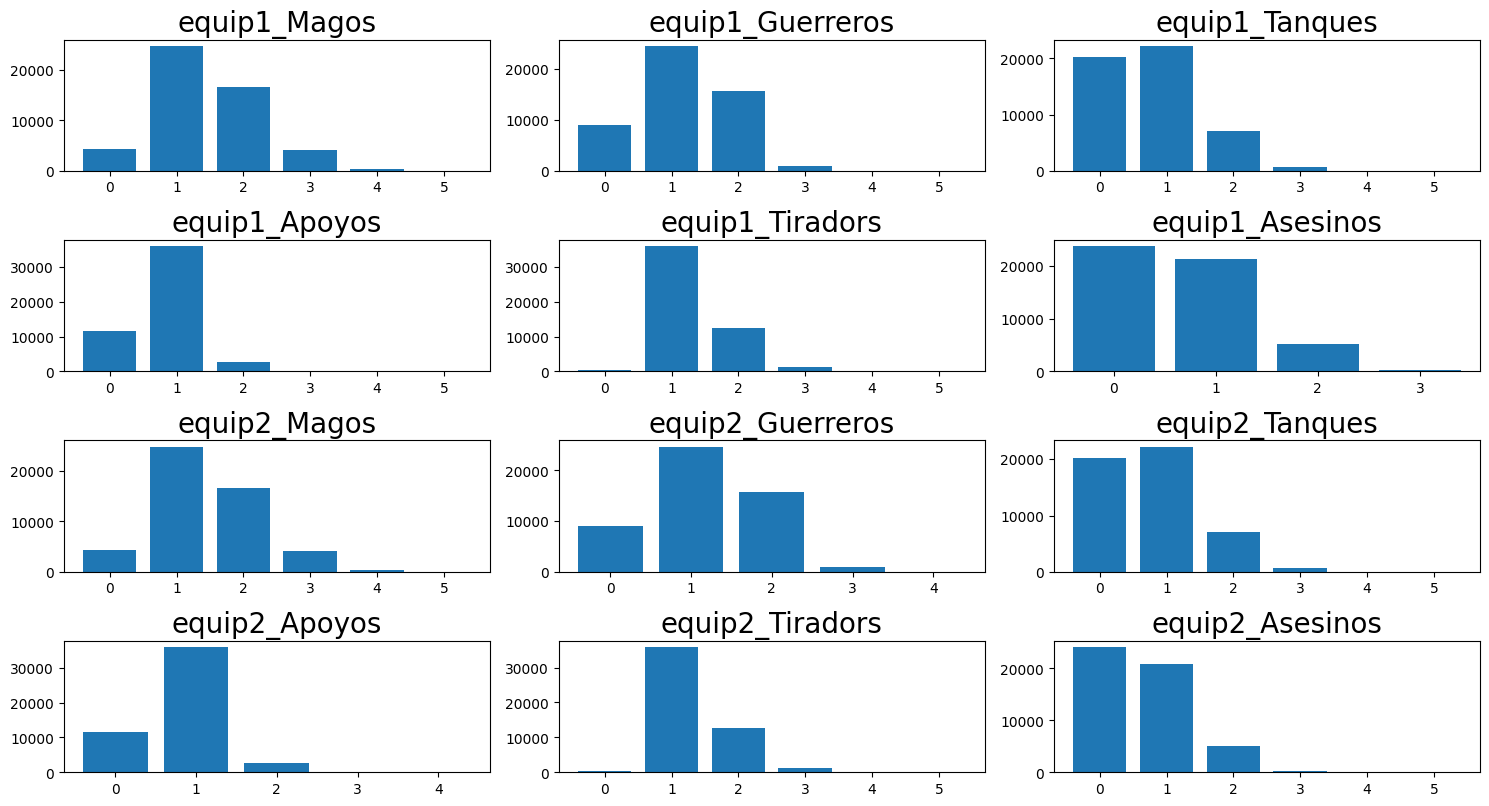

In [71]:

plt.figure(figsize=(15, 40))

m=1

for i in columnes_a_afegir: 
    plt.subplot(20,3, m)
    m+=1
    x=df[i].value_counts()

    plt.title(i, fontsize=20)

    plt.bar(x.keys(),x)
    if len(x.keys())<=10: 
        plt.xticks(x.keys(),  fontsize=10)

plt.tight_layout()
plt.show()

Decidim treure les columnes de bans, que son els campions que s'han elegit per a que no es poguin jugar. Aquesta columna perd tota la importancia ja que en cap cas ens esta informat del que esta passant en la partida. 

In [72]:
columnes_de_bans=['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4','t1_ban5', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']
df=df.drop(columnes_de_bans, axis=1)
df.columns

Index(['gameDuration', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id',
       't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1',
       't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id',
       't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills', 'equip1_Magos', 'equip1_Guerreros',
       'equip1_Tanques', 'equip1_Apoyos', 'equip1_Tir

Per normalitzar les dades hem de tenir en compte, que hi hagi moltes dades que semblen continues la realitat es que son categoriques i aquestes no les normalitzarem. Per tant l'única columna que normalitzarem sera la de gameDuration. Utilitzarem la StandardScaler que es basa en la funcio normal, al igual que els valors que trobem a la nostra grafica. (com representem a continuació)

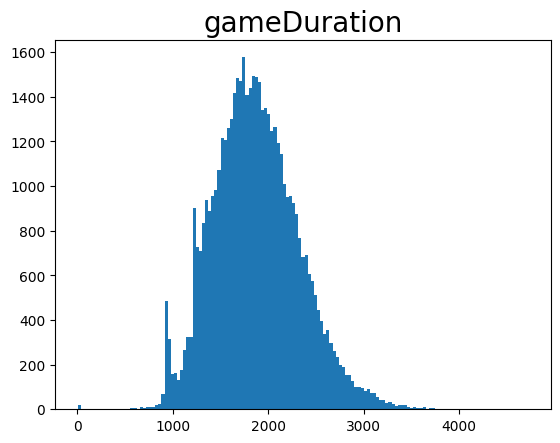

In [73]:
plt.hist(df["gameDuration"], bins="auto")
plt.title("gameDuration", fontsize=20)
plt.show()

Mirem si trobem correlacio entre les diferents variables que disposem

Text(0.5, 1.0, 'Matriu de correlació')

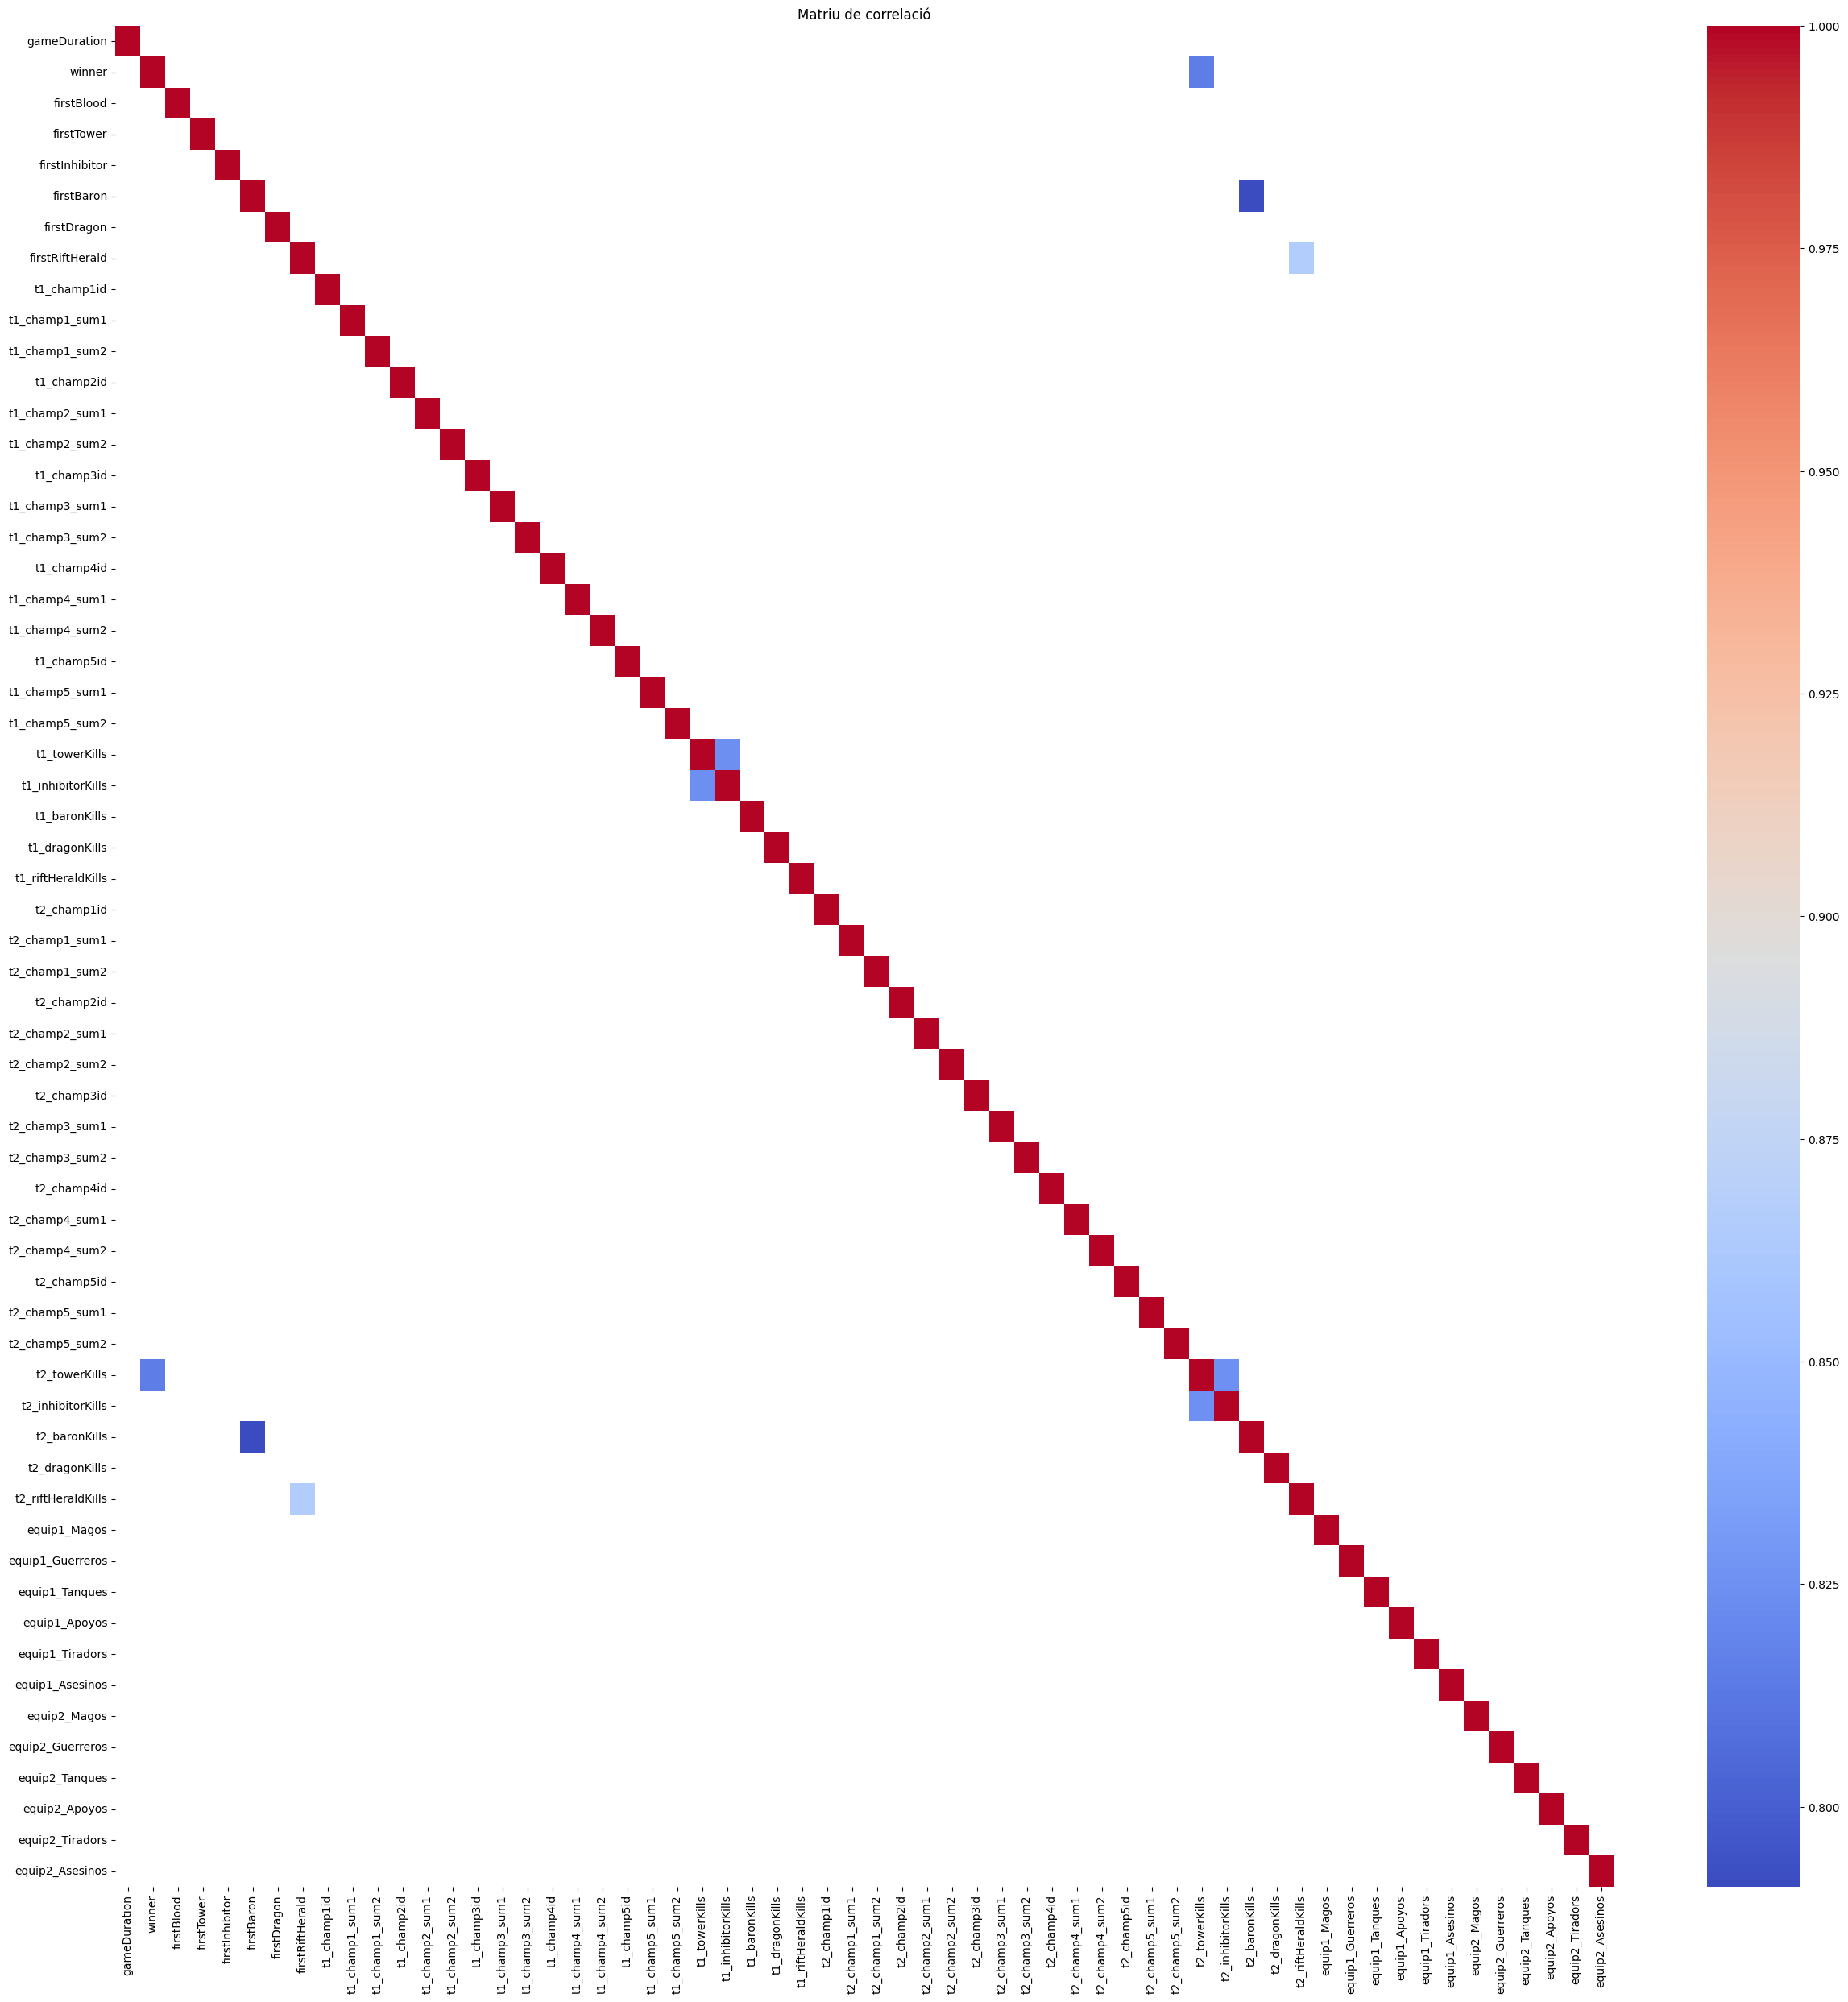

In [74]:

correlation_matrix = df.corr()
plt.figure(figsize=(30, 30))
high_corr = correlation_matrix[correlation_matrix > 0.75]#nomes mostrem aquelles que estan fortament correlacionades
matrix=sns.heatmap(high_corr, cmap='coolwarm', fmt='.1f', annot=False)


matrix.set_title("Matriu de correlació")

Veiem que hi ha dades correlacoinades entre elles, per tant al crear el model sembla que el millor serà utilitzar regularització, Lasso o Ridge. 

Per ultim pero no menys important, ens hem adonat que els valors t1_champ1id, t1_champ2id ... Estan representats amb dades numeriques pero que en realitat son categoriques, hem optat per a cambiar el valor per al nom que en trobem al arxiu champion_info

In [75]:

columnes_a_afegir=["t1_champ1id_name", "t1_champ2id_name", "t1_champ3id_name", "t1_champ4id_name", "t1_champ5id_name", 
                   "t2_champ1id_name", "t2_champ2id_name", "t2_champ3id_name", "t2_champ4id_name", "t2_champ5id_name"]
for col in columnes_a_afegir: 
    df[col]=[""]*df.shape[0]

def canvi_noms(row):
    for columna in columnes_campions_equip1:
        if(str(row[columna]) in data_json["data"]):
            row[f'{columna}_name']=data_json["data"][str(row[columna])]["name"]  
    
    for columna in columnes_campions_equip2:
        if(str(row[columna]) in data_json["data"]):
            row[f'{columna}_name']=data_json["data"][str(row[columna])]["name"]   
    return row


df=df.apply(canvi_noms, axis=1)
df.drop(columnes_campions_equip1,inplace=True, axis=1)
df.drop(columnes_campions_equip2,inplace=True, axis=1)


També farem one hot encoding dels valors de les columnes sum1/sum2. Ja que un valor de 10 no vol dir que es millor que 1. Si no que te un altre tipus de "habilitat" el qual en el joc s'anomena "summoner" o  en espanyol "hechizo de invocador". Aixo ens provocara tenir moltes columnes noves, ja que per cada campió tindrem n columnes (on n es el nombre d'aquests habilitats que hi ha). I tenim un total de 10 campions.
Farem un one-hot encoding on sum1 i sum2 crearan n columnes amb nombes 2 valors a true. 

In [76]:


def EncodingOneHot(X):
    data=deepcopy(X) #fet per a que funcioni be amb el Pipeline
    columnes_one_hot_encoder={"t1_c1":["t1_champ1_sum1", "t1_champ1_sum2"], 
                            "t1_c2":["t1_champ2_sum1", "t1_champ2_sum2"], 
                            "t1_c3":["t1_champ3_sum1", "t1_champ3_sum2"], 
                            "t1_c4":["t1_champ4_sum1", "t1_champ4_sum2"], 
                            "t1_c5":["t1_champ5_sum1", "t1_champ5_sum2"], 
                            "t2_c1":["t2_champ1_sum1", "t2_champ1_sum2"], 
                            "t2_c2":["t2_champ2_sum1", "t2_champ2_sum2"], 
                            "t2_c3":["t2_champ3_sum1", "t2_champ3_sum2"], 
                            "t2_c4":["t2_champ4_sum1", "t2_champ4_sum2"], 
                            "t2_c5":["t2_champ5_sum1", "t2_champ5_sum2"],         
                            }  
    summoners_by_champs=[]
    for i in columnes_one_hot_encoder:
        if  not (columnes_one_hot_encoder[i][0] in data.columns and columnes_one_hot_encoder[i][1] in data.columns):
             print(columnes_one_hot_encoder[i][1])
             print(columnes_one_hot_encoder[i][0])
             continue
        columna_combinada =pd.concat([data[columnes_one_hot_encoder[i][0]],data[columnes_one_hot_encoder[i][1]]], axis=0,  ignore_index=True) 
        aux=columna_combinada.unique()
        #print(aux)
        summoners_by_champs.append(aux)#guardem les columnes per despres el predict
        for spell in aux: 
            data[f'{spell}_{i}']=0#creem les noves columnes al train
        
       
        
        for key, spell in data[columnes_one_hot_encoder[i][0]].items(): 
            data.at[key, f'{spell}_{i}']=1
           
        for key, spell in data[columnes_one_hot_encoder[i][1]].items(): 
            data.at[key, f'{spell}_{i}']=1
    
    for i in columnes_one_hot_encoder: 
        data.drop([columnes_one_hot_encoder[i][0], columnes_one_hot_encoder[i][1]], inplace=True, axis=1)

    return summoners_by_champs

#comprobar que la funcio va correctament
#df_aux=deepcopy(df)
#EncodingOneHot(df_aux, columnes_one_hot_encoder)

Al fer la comprovació de si la funció anaba bé ens hem trobat que hi ha hi ha columnes de summoners del mateix campió que tenen el mateix valor. Per exemple: t1_champ1_sum1 == t1_champ1_sum2. Aixo no es pot donar al joc(ho sabem per que hem jugat). Llavors en aquest cas no fa falta fer un tractament especial ja que amb el one-hot-encoding ja realment estem fent que si hi ha un valor repetit només es tingui en compte una vegada.

In [77]:
count=0
print("Les columnes que tenim ara son les següents")
for x, y in zip(df["t1_champ1_sum1"], df["t1_champ1_sum2"]):
    if(x==y):
        count+=1
        
print(f"Tenim {count} valors repetits en columnes t1_champ1_sum1 t1_champ1_sum2")


Les columnes que tenim ara son les següents
Tenim 18 valors repetits en columnes t1_champ1_sum1 t1_champ1_sum2


Per ultim, com hem vist anteriorment busquem predir els valors de la columna "winner", on aquest pren valors 1 o 2. Convertirem els valors 1 a 0  y 2 a 1. Simplement per a que el model sigui mes fàcil de comprendre i com es un clasificador pot ajudar a simplificar el model.
Per tant ara un valor de 1 en "Winner" indica que el equip 2 a guanyat 

In [78]:
df["winner"]=df["winner"]-1

### 3. Metric selection

Com l'atribut que es busca predir és "Winner" i aquest es troba  balancejat creiem que la millor mètrica per al nostre model és l'accuracy.

Seguidament genero unes funcions que ens serviran per evaluar el model, tant per mostrar les corves pr, roc com per a calcular l'accuracy

In [79]:
def show_pr_curve(model, x, y, classifier_name):

    # predict probabilities
    y_prob = model.predict_proba(x)

    # keep probabilities for the positive outcome only
    y_prob = y_prob[:, 1]

    precision, recall, _ = precision_recall_curve(y, y_prob)

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', lw=2, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {classifier_name}')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

In [80]:
def show_roc_curve_binary(model, x, y, classifier_name):

    ns_probs = [1 for _ in range(len(y))] 
    probs = model.predict_proba(x)
    probs = probs[:, 1]

    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    fpr, tpr, threshold = roc_curve(y, probs)

    # Plot stuff:
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sense capacitat predictiva')
    plt.plot(fpr, tpr, marker='.', label=classifier_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')
    plt.legend()
    plt.show()

In [81]:
def show_performance(x, y, model, title=''):

    predictions = model.predict(x)
    accuracy=accuracy_score(y, predictions)
    accuracy=round(accuracy, 3)
    
    conf_mat = confusion_matrix(y, predictions)

    # Per PR Curve, necessitem les probabilitats de cada classe:
    

    
    print('-' * 25)
    print(f'>>> Accuracy del model: {accuracy}')
    print('-' * 25)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot()
    plt.title(f'{title} Conf. Mat.')
    plt.show()

    return accuracy



### 4. Model Selection 

Primer de tot creem una funció auxiliar que ens servira per a cada model trobar els millors hiperparàmetres, fent ús de GridSearchCv: 

In [82]:
def hyperparameter_tuning(model, params, x_train, y_train, folds=10, score="accuracy"):
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=folds, n_jobs=-1, scoring=score)
    grid_search.fit(x_train, y_train)

    print(f"Millors hiperparànetres: {grid_search.best_params_} amb accuracy {grid_search.best_score_}")

    return grid_search.best_estimator_

Separem les dades que utilitzem al train i al test final

In [83]:
target_attribut="winner"
df_sense_var_categoriques=deepcopy(df)
X=df.drop([target_attribut], axis=1, inplace=False)
y=df[[target_attribut]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Com hi ha models (com Logistic Regression) que  no manejen valors categorics hem de borrar les columnes que en tenen (aquelles dels campions on habiem posat el nom),
# com habiem generat  unes columnes (el tipus de campió: Mago, Guerrero...) a partir d'aquestes no es un impediment massa important
df_sense_var_categoriques.drop(columnes_a_afegir, axis=1, inplace=True)
X_sense_var_categoriques=df_sense_var_categoriques.drop([target_attribut], axis=1, inplace=False)
y_sense_var_categoriques=df_sense_var_categoriques[[target_attribut]]

X_train_no_cat, X_test_no_cat, y_train_no_cat, y_test_no_cat = train_test_split(X_sense_var_categoriques, y_sense_var_categoriques, test_size=0.2, stratify=y)

In [84]:
class OneHotEncodingPersonalitzat(BaseEstimator):
    def __init__(self):
        self.columnes_one_hot_encoder={"t1_c1":["t1_champ1_sum1", "t1_champ1_sum2"], 
                            "t1_c2":["t1_champ2_sum1", "t1_champ2_sum2"], 
                            "t1_c3":["t1_champ3_sum1", "t1_champ3_sum2"], 
                            "t1_c4":["t1_champ4_sum1", "t1_champ4_sum2"], 
                            "t1_c5":["t1_champ5_sum1", "t1_champ5_sum2"], 
                            "t2_c1":["t2_champ1_sum1", "t2_champ1_sum2"], 
                            "t2_c2":["t2_champ2_sum1", "t2_champ2_sum2"], 
                            "t2_c3":["t2_champ3_sum1", "t2_champ3_sum2"], 
                            "t2_c4":["t2_champ4_sum1", "t2_champ4_sum2"], 
                            "t2_c5":["t2_champ5_sum1", "t2_champ5_sum2"],         
                            }  
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X): 
        #print(type(X)) #debe ser tipo pandas
        self.encoding=EncodingOneHot(X)
        return X
    
    def predict(self, X): 
        equips=["t1", "t2"]
        champ=0
        noves_columnes=pd.DataFrame()
        while champ !=9:
            equip=equips[int(champ>4)]
            encoding_champ=self.encoding[champ]
            for spell in encoding_champ:
                noves_columnes[f'{spell}_{equip}_c{champ+1}']=[0]*X.shape[0] 
               
            champ+=1
        
        index=0
        for _, row in X.iterrows():
            for columna in self.columnes_one_hot_encoder: 
                #print(columna)
                #print(row)
                #print(self.columnes_one_hot_encoder[columna][0])
                value1=row[self.columnes_one_hot_encoder[columna][0]]
                value2=row[self.columnes_one_hot_encoder[columna][1]]
                if f'{value1}_{columna}' in noves_columnes:
                    noves_columnes.loc[index, f'{value1}_{columna}']+=1
                if f'{value2}_{columna}' in noves_columnes:
                    noves_columnes.loc[index, f'{value2}_{columna}']+=1
                
            index+=1

        for i in self.columnes_one_hot_encoder: 
            X.drop([self.columnes_one_hot_encoder[i][0], self.columnes_one_hot_encoder[i][1]], inplace=True, axis=1)

        X=pd.concat([X, noves_columnes], axis=1)

        return X


        

Cració d'un pipeline

In [85]:


def createPipeline(model):
    preprocessor=ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), ["gameDuration"])
        ], 
        remainder='passthrough' #no cambiar el resta de columnes
    )
    pipeline = Pipeline([
        ("Encoding", OneHotEncodingPersonalitzat()), #Pas 1: fer en encoding
        ('preprocessor', preprocessor),  # Pas 2: Normalizar  #PROBLEMA ESTA DEVOLVIENDO UN NUMPY ARRAY
        ('model', model)                # Pas 3: Model
    ])

    return pipeline

Ara el que farem es probar diversos models d'aprenentatge per veure amb quin trobem millors resultats. Els models utilizats seran: 
Regressió Logistica, Màquina de suport de Vectors(SVM), K-Nearest Neighbors(KNN) i Xarxa Neuronals Feedforward(la informació té una unica direcció)

#### Logistic Regression

In [86]:
lr=LogisticRegression()
params_lr=dict(model__penalty=["l1", "l2"], model__C=[0.01, 0.1, 1, 3], model__solver=["liblinear"])


#Com Logistic Regression no maneja valors categorics hem de borrar les columnes que en tenen (aquelles dels campions on habiem posat el nom),
# com habiem generat  unes columnes (el tipus de campió: Mago, Guerrero...) a partir d'aquestes no es un impediment massa important



pipeline_lr=createPipeline(lr)

estimator_lr=hyperparameter_tuning(pipeline_lr, params_lr, X_train_no_cat, y_train_no_cat.values.ravel(), folds=5)


Millors hiperparànetres: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'} amb accuracy 0.9726854728470237


-------------------------
>>> Accuracy del model: 0.973
-------------------------


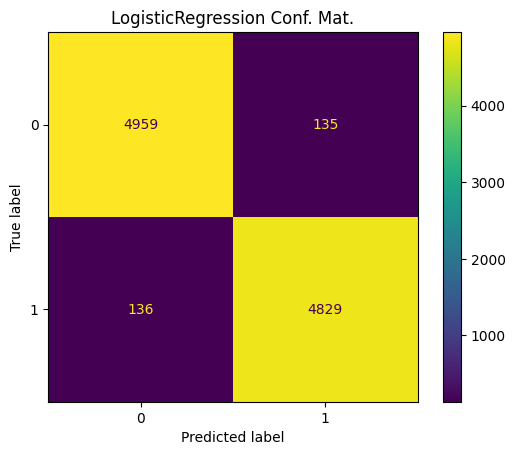

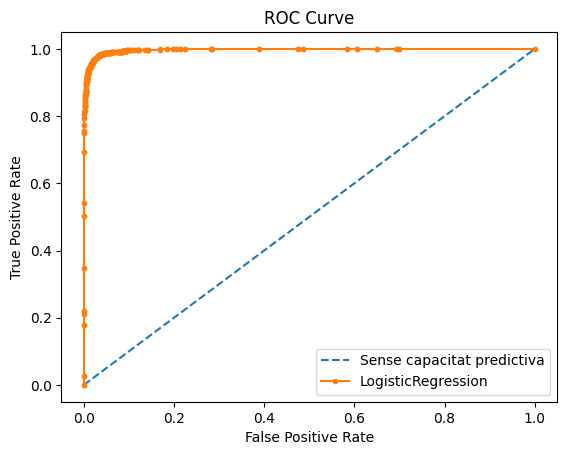

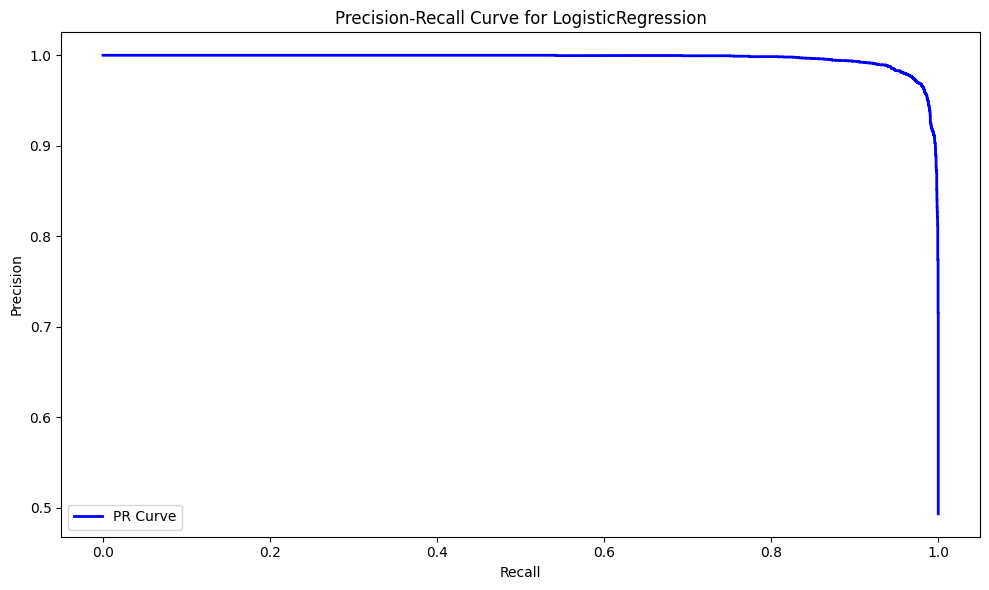

In [90]:
show_performance(X_test_no_cat, y_test_no_cat, estimator_lr, "LogisticRegression")
show_roc_curve_binary(estimator_lr, X_test_no_cat, y_test_no_cat, "LogisticRegression")
show_pr_curve(estimator_lr, X_test_no_cat, y_test_no_cat, "LogisticRegression")

In [91]:
svc=SVC()
params_svc=dict(model__degree=[1,2,3,5,7], model__decision_function_shape=['ovo', 'ovr'],  model__C=[0.01, 0.1, 1, 3], model__kernel=["poly", "rbf"])

pipeline_svc=createPipeline(svc)

estimator_svc=hyperparameter_tuning(pipeline_svc, params_svc, X_train_no_cat, y_train_no_cat.values.ravel(), folds=5)

KeyboardInterrupt: 

In [ ]:
show_performance(X_test_no_cat, y_test_no_cat, estimator_svc, "SVC")
show_roc_curve_binary(estimator_svc, X_test_no_cat, y_test_no_cat, "SVC")
show_pr_curve(estimator_svc, X_test_no_cat, y_test_no_cat, "SVC")